Implementation of Recurrent Neural Networks for Stock Price Prediction
===

In this project, we aim to implement a Recurrent Neural Network (RNN) model to predict Amazon stock prices using historical data. Stock price prediction is a well-known time series problem, where the goal is to forecast future stock prices based on past price movements. The stock market is highly volatile, making this task both challenging and interesting for machine learning applications.

We use a dataset containing Amazon's stock prices until 2025, which includes the daily closing price of the stock. The objective is to create a model capable of learning from the historical price data and generating predictions for future prices. RNNs are particularly suited for this type of problem due to their ability to capture temporal dependencies in sequential data.

The dataset will be preprocessed, normalized, and split into training and validation sets. An RNN model will then be trained on this data, and its performance will be evaluated using a loss function suitable for regression tasks, such as Mean Squared Error (MSE).

## Sourcing Data

In this section, we will download and load the Amazon stock price data from Kaggle. The dataset contains various attributes, including the opening price, closing price, volume, and more. However, for the purpose of this project, we will focus on the Close Price as it is one of the most important indicators for stock price prediction.

After downloading and extracting the dataset, we will preprocess the data by normalizing the Close Price. Normalization is essential in machine learning, as it standardizes the data, making it easier for the model to learn meaningful patterns. The Close Price will be transformed to have a mean of 0 and a standard deviation of 1, ensuring that the data is scaled correctly for training.

Finally, we will prepare the data by selecting the relevant columns and creating a new DataFrame that will be used in the subsequent steps of the modeling process.

### Amazon Stocks 2025

> author: Mehar Shan Ali

This dataset provides historical stock market data for Amazon (AMZN), one of the world's largest technology companies. The data has been sourced from Yahoo Finance and includes essential stock market attributes, allowing investors, analysts, and data scientists to analyze market trends, volatility, and stock performance.

In [4]:
!kaggle datasets download "meharshanali/amazon-stocks-2025"

Dataset URL: https://www.kaggle.com/datasets/meharshanali/amazon-stocks-2025
License(s): CC0-1.0


In [5]:
!unzip *.zip

Archive:  amazon-stocks-2025.zip
  inflating: AMZN_stock_data.csv     


### Processing dataset

This dataset contains the following stock attributes:

    Date: The trading date for Amazon stock.
    Open Price: The price at which the stock began trading on a given day.
    High Price: The highest price recorded for the stock during the trading session.
    Low Price: The lowest price recorded for the stock during the trading session.
    Close Price: The final trading price of the stock at the end of the day.
    Volume: The number of shares traded on a specific day.
    Dividends: The amount of dividend issued per share (if any).
    Stock Splits: Information on stock splits that occurred over time.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("AMZN_stock_data.csv", parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1,1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
2,1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
3,1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
4,1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


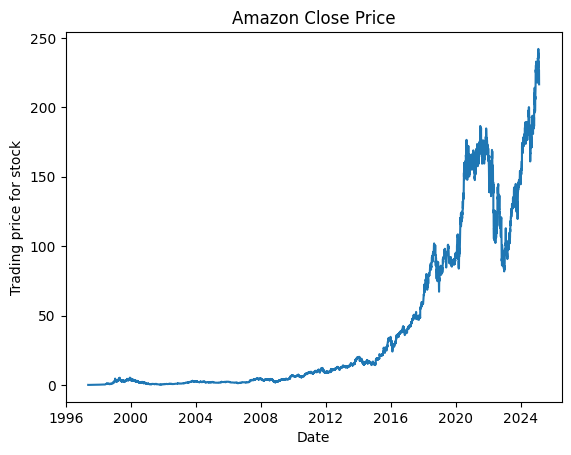

In [3]:
plt.plot(df["Date"], df['Close'])
plt.xlabel('Date')
plt.ylabel('Trading price for stock')
plt.title('Amazon Close Price')
plt.show()

In [4]:
data = df[["Date", "Close"]].copy()

close_prices = df['Close'].values.astype(np.float32)
normalized_close = (close_prices - np.mean(close_prices)) / np.std(close_prices)

data["Close_Normalized"] = normalized_close

data.head()

,Date,Close,Close_Normalized
0,1997-05-15 00:00:00-04:00,0.097917,-0.698321
1,1997-05-16 00:00:00-04:00,0.086458,-0.698519
2,1997-05-19 00:00:00-04:00,0.085417,-0.698536
3,1997-05-20 00:00:00-04:00,0.081771,-0.698599
4,1997-05-21 00:00:00-04:00,0.071354,-0.698778


In [5]:
SEQUENCE_LEN = 30 # Days
BATCH_SIZE = 32
sequences = []
targets = []

for i in range(len(data) - SEQUENCE_LEN):
    sequences.append(data.iloc[i:i + SEQUENCE_LEN][['Close_Normalized']].values)
    targets.append(data.iloc[i + SEQUENCE_LEN]['Close_Normalized'])

sequences, targets = np.array(sequences), np.array(targets)
sequences_train, sequences_val, targets_train, targets_val = train_test_split(
    sequences, targets, test_size=0.2, shuffle=False
)

print(f"Training data size: {sequences_train.shape}, {targets_train.shape}")
print(f"Validation data size: {sequences_val.shape}, {targets_val.shape}")

Training data size: (5565, 30, 1), (5565,)
Validation data size: (1392, 30, 1), (1392,)


## Building RNN

In this section, we will build a Recurrent Neural Network (RNN) model to predict Amazon stock prices. RNNs are well-suited for time series data because they can capture temporal dependencies in sequences, making them ideal for tasks like stock price forecasting.

We start by defining a custom RNN class using PyTorch. The model consists of the following components:

- RNN Layer: The core of the model, which processes the input data sequentially. It has a hidden size of 64 units and is composed of 2 layers.
- Fully Connected Layer: After the RNN layer, a fully connected (FC) layer is used to map the hidden state of the RNN to the final output, which in this case is a single predicted price value.

- Forward Pass: The forward method defines how the data flows through the RNN and the fully connected layer. We use only the last hidden state from the RNN as the relevant feature for prediction.

In [6]:
import torch
import torch.nn as nn

In [7]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.history = {'train': [], 'val': []}
    
    def forward(self, x):
        return self.fc(self.rnn(x)[0][:, -1, :])

    def fit(self, train_data, val_data, optimizer, criterion, n_epochs=20, verbose=True):
        train_input, train_target = train_data
        val_input, val_target = val_data
        
        for epoch in range(n_epochs):
            self.train()
            optimizer.zero_grad()
            train_outputs = self(train_input)
            train_loss = criterion(train_outputs.squeeze(), train_target)
            train_loss.backward()
            optimizer.step()

            self.eval()
            with torch.no_grad():
                val_outputs = self(val_input)
                val_loss = criterion(val_outputs.squeeze(), val_target)
            
            self.history['train'].append(train_loss.item())
            self.history['val'].append(val_loss.item())
            
            if verbose:
                print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

In [8]:
tensorify = lambda i: torch.tensor(i, dtype=torch.float32)

## Training & Results

In this section, we train the Recurrent Neural Network (RNN) model on the training data and evaluate its performance using the validation data. The model is optimized with the Adam optimizer and uses Mean Squared Error (MSE) as the loss function, which is commonly used for regression tasks.

The MSE is calculated by taking the average of the squared differences between the predicted and actual values. It is a standard metric for continuous data, such as stock prices, as it penalizes larger errors more significantly, helping the model focus on minimizing large prediction discrepancies.

The model is trained for 100 epochs, and during each epoch, the training and validation losses are recorded. These losses reflect how well the model is learning to predict the stock prices. We then visualize the training history by plotting the loss values for both training and validation sets over the course of the epochs.

In [9]:
model = StockPriceRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
model.fit(
    train_data=[tensorify(i) for i in [sequences_train, targets_train]],
    val_data=[tensorify(i) for i in [sequences_val, targets_val]],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=100    
)
torch.save(model.state_dict(), 'stock_price_rnn.pth')

Epoch [1/100], Train Loss: 0.3827, Validation Loss: 3.4901
Epoch [2/100], Train Loss: 0.3043, Validation Loss: 3.5973
Epoch [3/100], Train Loss: 0.2396, Validation Loss: 3.7062
Epoch [4/100], Train Loss: 0.1871, Validation Loss: 3.8111
Epoch [5/100], Train Loss: 0.1470, Validation Loss: 3.8900
Epoch [6/100], Train Loss: 0.1215, Validation Loss: 3.8963
Epoch [7/100], Train Loss: 0.1132, Validation Loss: 3.7641
Epoch [8/100], Train Loss: 0.1173, Validation Loss: 3.4841
Epoch [9/100], Train Loss: 0.1185, Validation Loss: 3.1281
Epoch [10/100], Train Loss: 0.1083, Validation Loss: 2.7653
Epoch [11/100], Train Loss: 0.0901, Validation Loss: 2.4287
Epoch [12/100], Train Loss: 0.0713, Validation Loss: 2.1237
Epoch [13/100], Train Loss: 0.0566, Validation Loss: 1.8426
Epoch [14/100], Train Loss: 0.0473, Validation Loss: 1.5772
Epoch [15/100], Train Loss: 0.0415, Validation Loss: 1.3245
Epoch [16/100], Train Loss: 0.0356, Validation Loss: 1.0861
Epoch [17/100], Train Loss: 0.0267, Validation Lo

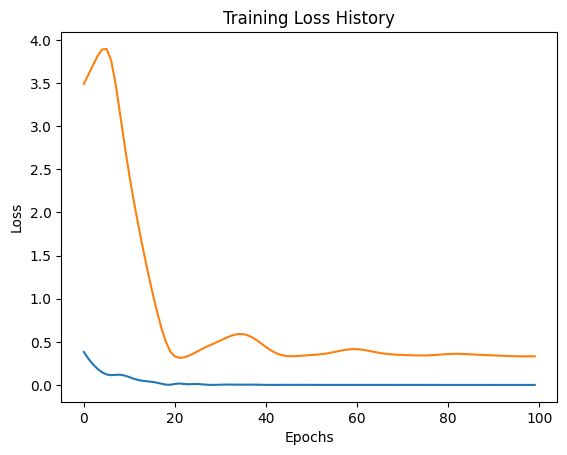

In [11]:
plt.plot(model.history["train"])
plt.plot(model.history["val"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

### Performance evaluation

- Steady Decrease in Loss: Both the training and validation losses decrease consistently throughout the training, with the validation loss dropping significantly faster than the training loss in the initial epochs.

- Validation Loss Plateau: After epoch 60, the validation loss starts to plateau, indicating that the model's performance on unseen data starts to stabilize, and further training brings diminishing improvements in generalization.

- Overfitting Analysis: The gap between the training and validation loss is relatively small, suggesting that the model is not overfitting. The validation loss does not increase significantly, indicating good generalization.